# Comparison of batch effect correction techniques
Batch correction for morphological profiles can be done in many ways.
Most commonly, profiles are z-scaled per plate. However, this step may remove
biological differences, for example between cell lines. In a more complex
experimental setup in which we wish to maintain differences between cell lines
but removes differences betwen batches, this approach may fail. For this case,
`scmorph` integrates a method that removes only the technical effects. This
notebook demonstrates the difference between the two approaches with some
simulated data.

It assumes the following experimental setup: the experiment was conducted across
four plates (i.e. batches) and comprises three cell lines. Plates 0-2 contain a
single cell line each (A-C). Plate 3 contains a sample of each cell line and is
termed "masterplate". This plate is important, because it allows `scmorph` to
measure the differences between cell lines and maintain them.

First, we will import the libraries necessary for the simulation and define the
simulation functions. It is not necessary to understand these functions on first
read, but if you would like to dive deeper into the simulation feel free to
modify the parameters and see how the results change.

In [1]:
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import anndata as ad
import scmorph as sm

In [ ]:
def concat(iter):
    """Convenience function for concatenating anndata objects"""
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="Observation names are not unique. To make them unique, call `.obs_names_make_unique`.",
        )
        return ad.concat(iter)


def simulate_plate(N=100, M=10, obs=None, offset=0):
    """Simulate a single plate. N is number of cells, M number of features, obs a dict of metadata, and offset a bias for this plate."""
    if obs is None:
        obs = {"bio": "A", "batch": "1"}
    rng = np.random.default_rng(2025)
    X = rng.multivariate_normal(np.zeros(M), np.eye(M), size=N)
    obs = pd.DataFrame(obs, index=np.arange(N).astype(str))
    adata = ad.AnnData(X=X, obs=obs)
    adata.X[:, 0] += offset
    return adata


def simulate_masterplate(offsets, N=100):
    """Simulate a masterplate which contains all cell lines with offsets defined in the dict."""
    n_cell_lines = len(offsets.keys())
    batch_id = n_cell_lines
    adatas = {}
    for k in offsets.keys():
        adatas[k] = simulate_plate(N, obs={"bio": k, "batch": batch_id}, offset=0)
        adatas[k].X[:, 0] += offsets[k]

    adata = concat(adatas.values())
    return adata


def simulate_experiment(N=100, batch_offsets=None, bio_offsets=None):
    """Simulate whole experiment including masterplate"""
    if batch_offsets is None:
        batch_offsets = {0: 2, 1: 5, 2: -5}
    if bio_offsets is None:
        bio_offsets = {"A": 0, "B": 10, "C": -10}
    bio_offsets_l = list(bio_offsets.keys())
    experimental_plates = [
        simulate_plate(N=N, obs={"bio": bio_offsets_l[i], "batch": str(k)}, offset=batch_offsets[k])
        for i, k in enumerate(batch_offsets.keys())
    ]
    experimental_plates = concat(experimental_plates)
    masterplate = simulate_masterplate(bio_offsets, N=N)

    adata = concat([masterplate, experimental_plates])
    adata.obs.index = np.arange(adata.shape[0]).astype(str)
    adata.obs["batch"] = adata.obs["batch"].astype(str).astype("category")
    adata.obs["bio"] = adata.obs["bio"].astype("category")
    sc.pp.subsample(adata, fraction=1)
    return adata

Now we will first simulate the experimental setup and show the differences
between cell lines ("bio") and batches ("batch") in the first two PCs. Note that
cell lines differences are simulated to be stronger than batch differences.

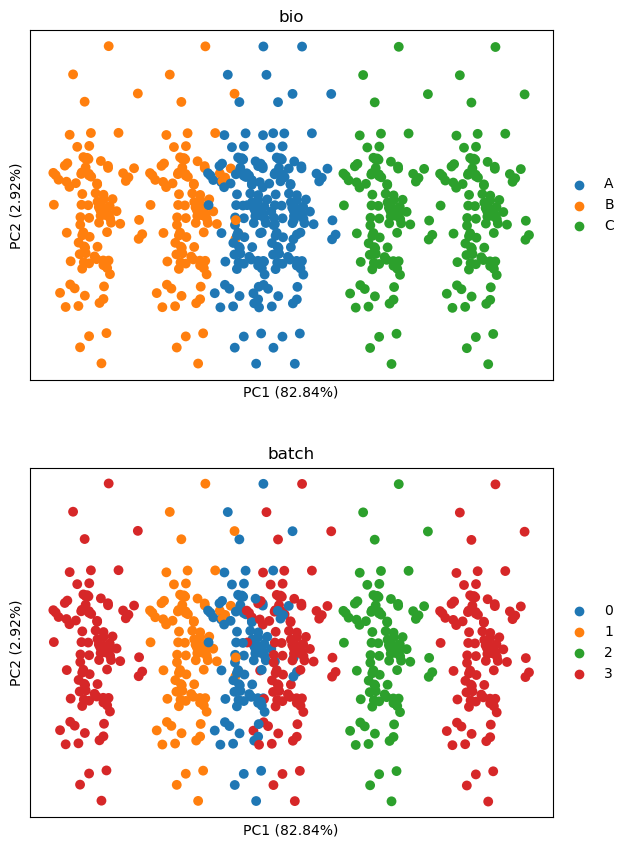

In [3]:
adata = simulate_experiment()
sm.pp.pca(adata)
sm.pl.pca(adata, color=["bio", "batch"], ncols=1)

The above shows that both batch and cell lines differences are present on PC1.
We wish to remove batch effects while keeping differences between cell lines.
The usual approach would be to perform z-scoring per plate. Let's see how this
performs here.

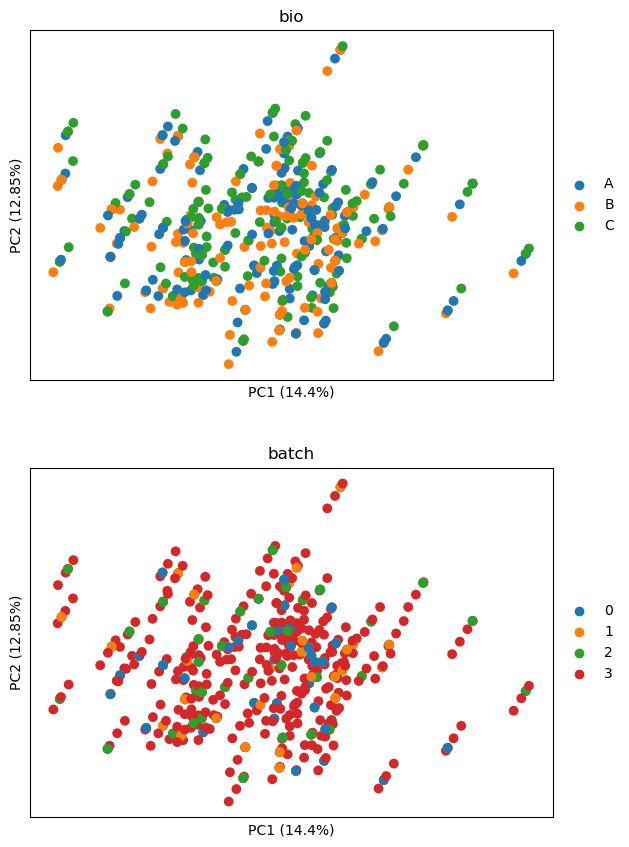

In [4]:
adata = simulate_experiment()
sm.pp.scale_by_batch(adata, batch_key="batch")
sm.pp.pca(adata)
sm.pl.pca(adata, color=["bio", "batch"], ncols=1)

Whie batch effects have largely been collapsed, all differences between cell
lines are gone too. This is because z-scaling does not readily remove batch
effects only. If, however, we use the linear model integrated in `scmorph`, we
can retain differences between cell lines.

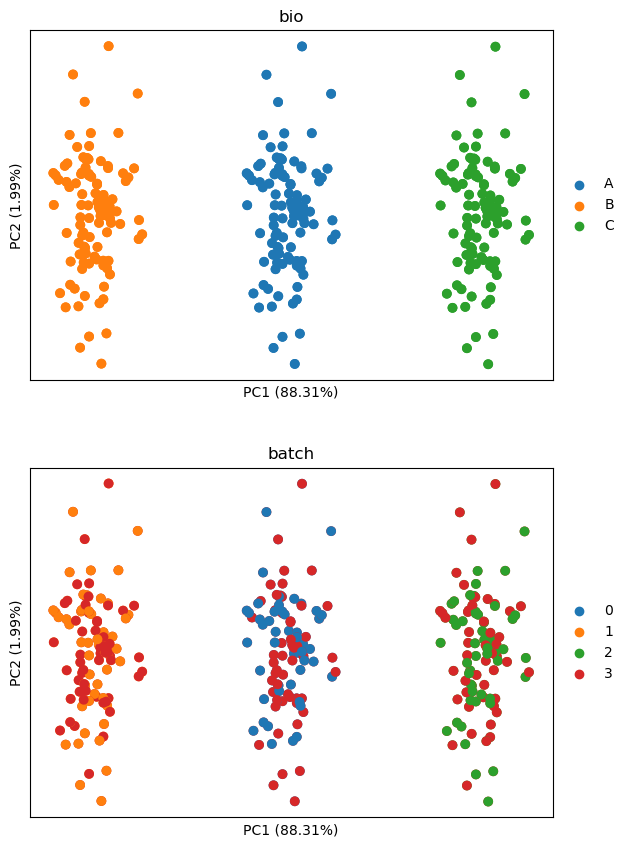

In [5]:
adata = simulate_experiment()
sm.pp.remove_batch_effects(adata, batch_key="batch", bio_key="bio")
sm.pp.pca(adata)
sm.pl.pca(adata, color=["bio", "batch"], ncols=1)

The above shows that batch effects are gone, but cell line differences are
retained as intended.

In conclusion, in scenarios where we wish to keep differences between separate
biological entities, researchers should opt for `remove_batch_effects` over `scale_by_batch`.